---



# <font color='#ECA702'>**Análisis Multimodal de Síntomas en la Enfermedad de Parkinson**</font>

In [24]:
#@title **Importar librerías**

# Manipulación de datos
import os
import cv2
import numpy as np
import librosa
import pandas as pd

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F

# Pytorch essentials for datasets.
from torch.utils.data import Dataset, DataLoader, ConcatDataset

# Utils
import matplotlib.pyplot as plt
from tqdm import tqdm

# sklearn
from sklearn.model_selection import GroupKFold

In [2]:
#@title **Cargamos los datos desde Drive**

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/data_parkinson')
print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1XRruCPRodR4OhRCRZYKsyODqa_GuBkfC/data_parkinson


## <font color='#4C5FDA'>**Procesamiento del dataset**</font>

### <font color='#52F17F'>**Preprocesamiento de los datos**</font>

In [3]:
"""
Constante sacada de la media de duración de todos los audios multiplicada por 0.1
para tener el 10%
"""
SEGUNDOS_PROMEDIO = 0.239328

"""
Constante sacada de la media de cantidad de frames de todos los vídeos multiplicada por 0.1
para tener el 10%
"""

FRAMES_PROMEDIO = 14

In [14]:
def preprocess_audio(audio:str):
  """
  Esta función calcula el espectograma mel en escala logarítmica de un audio
  con pasos de 25ms y una ventana de 40ms. Además usamos 90 bandas mel y un
  sampling rate de 48 kHz.

  Args:
    audio: path del audio
  Returns:
    log_mel_spectogram: An array of mel spectogram in the shape of (n_mels, n_frames).
  """
  samples, sample_rate = librosa.load(audio, sr = 48000, duration=SEGUNDOS_PROMEDIO)
  steps = int(25/(1/sample_rate*1000)) # Pasos de 25ms
  window = int(40/(1/sample_rate*1000)) # window (numero de samples por ventana) de 40ms

  # Encontramos el espectograma mel con 90 bandas.
  mel_spectogram = librosa.feature.melspectrogram(y=samples, sr=sample_rate, n_fft = window, hop_length=steps, n_mels = 90)

  # Lo movemos a escala logarítmica
  log_mel_spectogram = librosa.power_to_db(mel_spectogram)
  return log_mel_spectogram

#### <font color="6600CC">**Ejemplo con un sample**</font>

In [11]:
video_path = "AudioVisualData_v7/Control/C0/Phonemes/frames/C0-1-Pakata.mov"
frames = []
for frame in sorted(os.listdir(video_path))[:FRAMES_PROMEDIO]:
  # print(os.path.join(video_path,frame))
  frame_path = os.path.join(video_path, frame)
  frame = cv2.imread(frame_path)
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  frames.append(frame)
frames = np.stack(frames)
print(frames.shape)

(14, 642, 481, 3)


In [12]:
def plot_frame_strip(frames, rows=2, cols=7):
    """
    Hace un plot de la tira de frames en una matriz de imágenes.

    Args:
        frames (np.ndarray): Tensor de frames con forma (num_frames, height, width, channels).
        rows (int): Número de filas en la tira de frames.
        cols (int): Número de columnas en la tira de frames.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(20, 6))

    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < len(frames):
                axes[i, j].imshow(frames[idx])
                axes[i, j].axis('off')
                axes[i, j].set_title(f"Frame: {idx}")
    plt.show()

In [ ]:
# Realiza el plot de la tira de frames
plot_frame_strip(frames)

In [15]:
audio_path = "AudioVisualData_v7/Control/C0/Phonemes/audio/C0-1-Pakata.mp3"
audio = preprocess_audio(audio_path)
print(audio.shape, audio.dtype)

(90, 10) float32


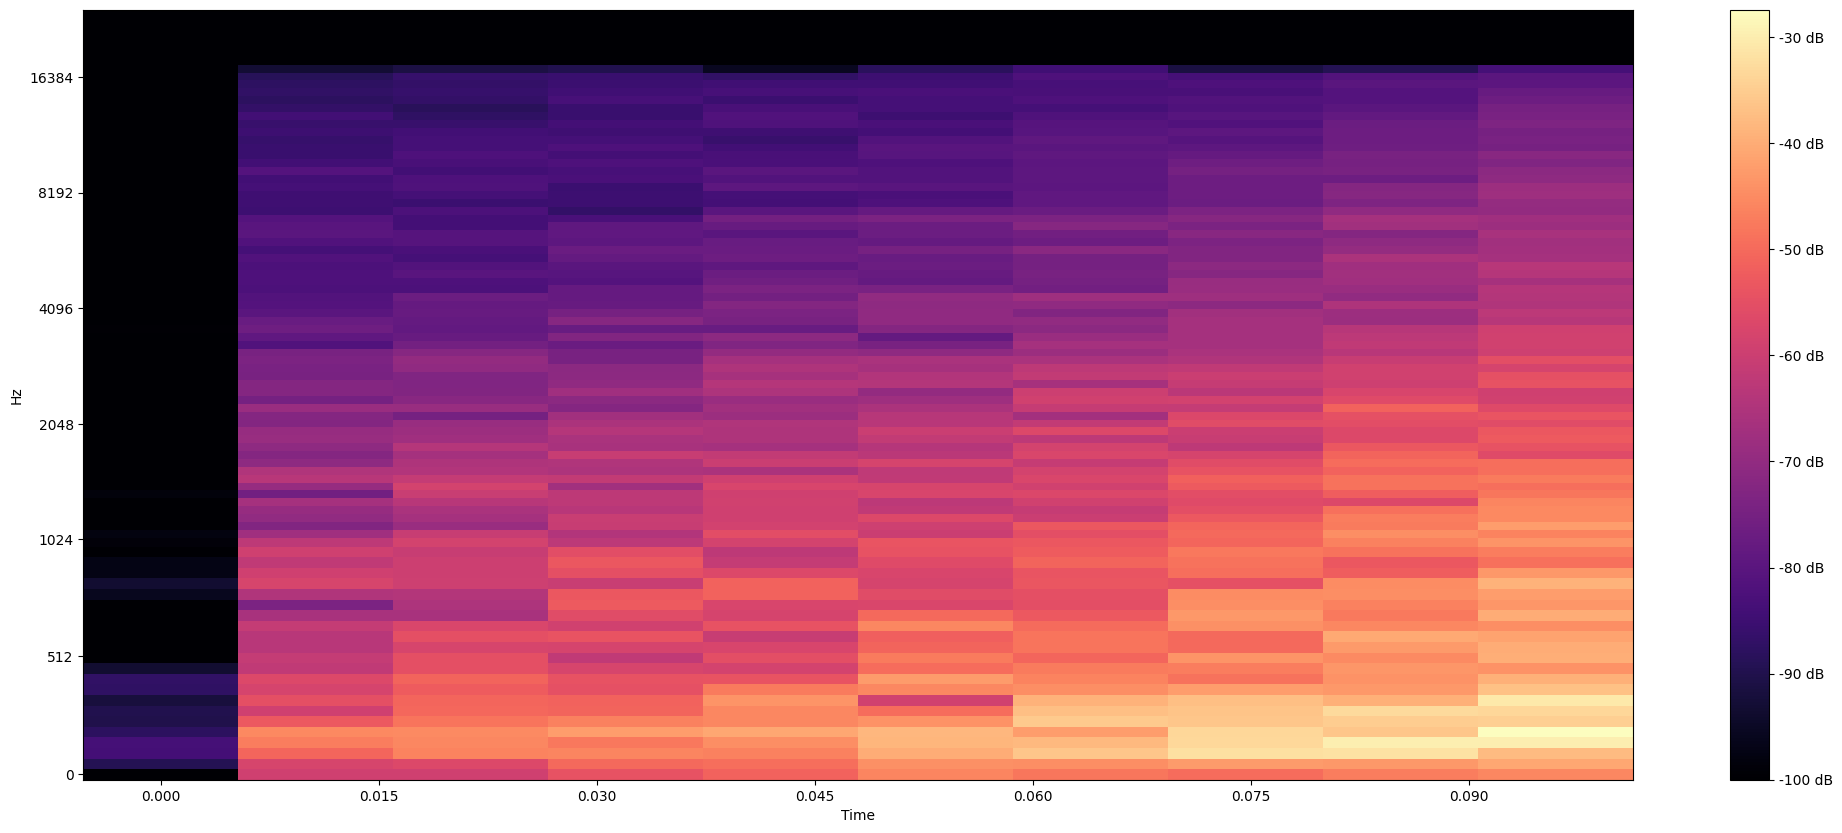

In [16]:
plt.figure(figsize=(25,10))
librosa.display.specshow(audio, y_axis='mel', x_axis='time', sr=48000)
plt.colorbar(format="%+2.f dB")
plt.show()

### <font color='#52F17F'>**Creación del Dataset Pandas auxiliar**</font>

In [74]:
# Directorio principal
main_directory = "AudioVisualData_v7"

patients = []
labels = []
frames = []
audios = []

"""
Esta construcción del dataset depende de la estructura del mismo
"""

# Itero por cada tipo de paciente: Control, Parkinson
for patient_type in os.listdir(main_directory):

  # A la ruta del directorio le concateno el tipo de paciente
  patient_type_path = os.path.join(f"{main_directory}/{patient_type}")

  # Itero por cada paciente en cada tipo de paciente
  for patient in os.listdir(patient_type_path):

    # A la ruta del tipo de paciente le concateno el paciente
    audio_type_path = os.path.join(f"{patient_type_path}/{patient}")

    # Itero por el tipo de sample: Phonemes, Vowels, Words
    for sample_type in os.listdir(audio_type_path):

      # Armo la ruta hasta el tipo de sample
      file_type_path = os.path.join(f"{audio_type_path}/{sample_type}")

      # Itero por cada registro en cada tipo de sample y le anaño audio a la ruta
      # para que entre de una vez a los registros
      for record in os.listdir(f"{file_type_path}/audio"):

        # Armo la ruta hasta el registro
        record_path = os.path.join(f"{file_type_path}/audio/{record}")
        # Agrego el paciente a la lista de pacientes
        patients.append(patient)
        # Agrego el label al final para asegurar que lo haga para cada paciente
        if patient_type == 'Parkinson':
          labels.append(1)
        else:
          labels.append(0)
        frames.append(record_path.replace('audio', 'frames').replace('.mp3', '.mov'))
        # Agrego la ruta del audio
        audios.append(record_path)

# Crear un DataFrame con la información
data = pd.DataFrame({
    'patient': patients,
    'audio_path': audios,
    'frames_path': frames,
    # 'type_path': dirs_type,
    'label': labels
})

data.set_index('patient', inplace=True)
data.head()

,audio_path,frames_path,label
patient,,,
P8,AudioVisualData_v7/Parkinson/P8/Vowels/audio/P...,AudioVisualData_v7/Parkinson/P8/Vowels/frames/...,1
P8,AudioVisualData_v7/Parkinson/P8/Vowels/audio/P...,AudioVisualData_v7/Parkinson/P8/Vowels/frames/...,1
P8,AudioVisualData_v7/Parkinson/P8/Vowels/audio/P...,AudioVisualData_v7/Parkinson/P8/Vowels/frames/...,1
P8,AudioVisualData_v7/Parkinson/P8/Vowels/audio/P...,AudioVisualData_v7/Parkinson/P8/Vowels/frames/...,1
P8,AudioVisualData_v7/Parkinson/P8/Vowels/audio/P...,AudioVisualData_v7/Parkinson/P8/Vowels/frames/...,1


### <font color='#52F17F'>**Creación del Dataset PyTorch**</font>

In [75]:
class PatientDataset(Dataset):
  def __init__(self, dataframe, n_frames = FRAMES_PROMEDIO):
    self.dataframe = dataframe
    # self.transform = transform
    self.n_frames = n_frames
    # self.audios = sorted(os.listdir(audio_dir)) # Listamos todas las imagenes en la carpeta

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):

    """ Carga de la imagen """

    # Entramos a la carpeta y conseguimos el audio de la lista
    # audio_path = os.path.join(self.audio_dir, self.audios[index])
    audio_path = os.path.join(self.dataframe['audio_path'][index])

    # Leemos el audio
    audio = preprocess_audio(audio_path)
    audio = torch.from_numpy(audio).unsqueeze(0)

    """ Carga de los frames """

    # Entramos a la carpeta y conseguimos los frames de la lista.
      # La razon por la que uso la misma lista de audios es porque el audio y el vídeo
      # tienen el mismo nombre, solo cambia la ruta de la carpeta y la extensión.
    """ audios: AudioVisualData_v7/Control/C0/Phonemes/audio/C0-1-Pakata.mp3 """
    """ vídeo: AudioVisualData_v7/Control/C0/Phonemes/frames/C0-1-Pakata.mov """
    video_path = os.path.join(self.dataframe['frames_path'][index])
    # video_path = os.path.join(self.video_dir, self.audios[index].replace(".mp3", ".mov"))

    frames_path = sorted(os.listdir(video_path))[:self.n_frames]
    frames = []
    for frame in frames_path:
      frame_path = os.path.join(self.dataframe['frames_path'][index], frame)
      # print(frame_path)
      frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
      frame = cv2.resize(frame, (112, 112)) # Resize a 112x112
      frame = frame / 255. # Normalizamos entre 0 y 1
      frames.append(frame)

    frames = np.expand_dims(np.stack(frames), axis=1).astype('float32')
    frames = frames.transpose(1, 0, 2, 3)
    frames = torch.from_numpy(frames)

    """ Consiguiendo el label """

    # Para conseguir la etiqueta simplemente me tengo que fijar en la ruta. Si es 'Parkinson' 1
    # sino 0.

    label = 1 if 'Parkinson' in self.dataframe['audio_path'][index] else 0

    return audio, frames, label

In [76]:
complete_dataset = PatientDataset(data)
print(complete_dataset.__len__())
print(complete_dataset[0][0].shape, complete_dataset[0][1].shape , complete_dataset[0][2])

1091
torch.Size([1, 90, 10]) torch.Size([1, 14, 112, 112]) 1


In [71]:
data['frames_path'][0]

'AudioVisualData_v7/Parkinson/P8/Vowels/frames/P8-2-U.mov'

### <font color='#52F17F'>**Partición de los datos**</font>

In [77]:
# Extraer los datos para GroupKFold https://discuss.pytorch.org/t/custom-datatype-for-many-images-to-one-label/87629
X = [i for i in range(len(data))]
y = data['label'].values
groups = data.index.values

In [78]:
groupk_folds = 7
gkf = GroupKFold(n_splits=groupk_folds)
# Realizar la validación cruzada por grupos
for i, (train_index, test_index) in enumerate(gkf.split(X, y, groups), 1):
    train_groups = groups[train_index]
    test_groups = groups[test_index]

    print(f"División {i}:")
    print("  Pacientes en entrenamiento:", np.unique(train_groups))
    print("  Pacientes en prueba:", np.unique(test_groups))
    print("  Número de pacientes en entrenamiento:", len(np.unique(train_groups)))
    print("  Número de pacientes en prueba:", len(np.unique(test_groups)))
    print()

División 1:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C3' 'C4' 'C6' 'P0' 'P1' 'P4' 'P5' 'P6' 'P7']
  Pacientes en prueba: ['C5' 'P8']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 2:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C3' 'C5' 'C6' 'P0' 'P1' 'P4' 'P5' 'P6' 'P8']
  Pacientes en prueba: ['C4' 'P7']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 3:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C4' 'C5' 'C6' 'P0' 'P1' 'P4' 'P5' 'P7' 'P8']
  Pacientes en prueba: ['C3' 'P6']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 4:
  Pacientes en entrenamiento: ['C0' 'C2' 'C3' 'C4' 'C5' 'C6' 'P0' 'P1' 'P4' 'P6' 'P7' 'P8']
  Pacientes en prueba: ['C1' 'P5']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 5:
  Pacientes en entrenamiento: ['C0' 'C1' 'C3' 'C4' 'C5' 'C6' 'P0' 'P1' 'P5' 'P6' 'P7' 'P8']
  Pacientes en prueba: [

## <font color='#ECA702'>**Modelo CNN**</font>

### <font color='#52F17F'>**Creando el modelo**</font>

In [79]:
class AudioModule(nn.Module):
  def __init__(self, n_channels, n_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(n_channels, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.pool = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(64, 32)
    self.gap = nn.AdaptiveAvgPool2d(1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.gap(x)
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    return x

In [80]:
# Test al modelo, para ver si nos entrega la salida esperada

n_channels = 1
n_classes = 2
input_audio = complete_dataset[0][0].unsqueeze(0)
print(f"Entrada: {input_audio.size()}")

model = AudioModule(n_channels=n_channels, n_classes=n_classes)
ouput = model(input_audio)
print(f"Salida: {ouput.size()}")

Entrada: torch.Size([1, 1, 90, 10])
Salida: torch.Size([1, 32])


In [81]:
class VideoModule(nn.Module):
  def __init__(self, n_channels, n_classes):
    super().__init__()
    self.conv1 = nn.Conv3d(n_channels, 32, 3, padding=1)
    self.conv2 = nn.Conv3d(32, 64, 3, padding=1)
    self.pool = nn.MaxPool3d(2)
    self.gap = nn.AdaptiveAvgPool2d(1)
    self.fc1 = nn.Linear(64 * 7, 32)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.gap(x)
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    return x

In [82]:
# Test al modelo, para ver si nos entrega la salida esperada

n_channels = 1
n_classes = 2
input_video = complete_dataset[0][1].unsqueeze(0)
print(f"Entrada: {input_video.size(), input_video.dtype}")

model = VideoModule(n_channels=n_channels, n_classes=n_classes)
ouput = model(input_video)
print(f"Salida: {ouput.size()}")

Entrada: (torch.Size([1, 1, 14, 112, 112]), torch.float32)
Salida: torch.Size([1, 32])


In [83]:
class MultimodalModel(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.audio_model = AudioModule(n_channels, n_classes)
        self.video_model = VideoModule(n_channels, n_classes)
        self.fc1 = nn.Linear(32 * 2, 32)
        self.fc2 = nn.Linear(32, 2)  # Suponiendo que es una tarea de clasificación binaria

    def forward(self, audio, video):
        audio_features = self.audio_model(audio)
        video_features = self.video_model(video)
        combined = torch.cat((audio_features, video_features), dim=1)
        x = F.relu(self.fc1(combined))
        x = self.fc2(x)
        return x

In [84]:
# Test al modelo, para ver si nos entrega la salida esperada

n_channels = 1
n_classes = 2
input_audio = complete_dataset[0][0].unsqueeze(0)
input_video = complete_dataset[0][1].unsqueeze(0)
print(f"Entrada audio: {input_audio.size(), input_audio.dtype}")
print(f"Entrada video: {input_video.size(), input_video.dtype}")

model = MultimodalModel(n_channels=n_channels, n_classes=n_classes)
ouput = model(input_audio, input_video)
print(f"Salida: {ouput.size()}")

Entrada audio: (torch.Size([1, 1, 90, 10]), torch.float32)
Entrada video: (torch.Size([1, 1, 14, 112, 112]), torch.float32)
Salida: torch.Size([1, 2])


### <font color='#52F17F'>**Entrenamiento del modelo**</font>

In [89]:
# Hiperparametros
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16

In [90]:
# For fold results
results = {}

In [91]:
# Loop encontrado y modificado de: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
for fold, (train_ids, test_ids) in enumerate(gkf.split(X, y, groups)):

  # Print
  print(f'FOLD {fold+1}')
  print('--------------------------------')

  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.Subset(complete_dataset, train_ids)
  test_subsampler = torch.utils.data.Subset(complete_dataset, test_ids)

  # Define data loaders for training and testing data in this fold
  trainloader = DataLoader(train_subsampler, batch_size=BATCH_SIZE, shuffle=True)
  testloader = DataLoader(test_subsampler, batch_size=BATCH_SIZE, shuffle=False)

  """ Parametros del modelo """

  # Creacion del modelo y lo movemos a la GPU o CPU
  model = MultimodalModel(n_channels=1, n_classes=2)
  model.to(DEVICE)

  # Funcion de perdida (loss)
  criterion = nn.CrossEntropyLoss()

  # Algoritmos de optimización del gradiente
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  epoch_number = 0

  EPOCHS = 2

  for epoch in range(EPOCHS):  # loop over the dataset multiple times
      print(f"EPOCH {epoch_number + 1}")

      running_loss = 0.0
      for i, data in enumerate(tqdm(trainloader, 0)):
          # get the inputs; data is a list of [inputs, labels]
          audios, videos, labels = data

          # Movemos los datos al device
          audios = audios.to(DEVICE)
          videos = videos.to(DEVICE)
          labels = labels.to(DEVICE)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(audios, videos)
          # print(ouputs.dtype)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 100 == 99:    # print every 100 mini-batches
              print(f'batch {i + 1:5d} loss: {running_loss / 100:.3f}')
              running_loss = 0.0
      epoch_number += 1 # Pasamos a la siguiente época

  # Process is complete.
  print('Training process has finished. Saving trained model.')

  # Print about testing
  print('Starting testing')

  # Saving the model
  save_path = f'../models/model-fold-{fold}.pth'
  torch.save(model.state_dict(), save_path)

  # Evaluationfor this fold
  correct, total = 0, 0
  with torch.no_grad():

    # Iterate over the test data and generate predictions
    for i, data in enumerate(testloader, 0):

      # Get inputs
      audios, videos, labels = data

      # Movemos los datos al device
      audios = audios.to(DEVICE)
      videos = videos.to(DEVICE)
      labels = labels.to(DEVICE)

      # Generate outputs
      outputs = model(audios, videos)

      # Set total and correct
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (fold+1, 100.0 * correct / total))
    print('--------------------------------')
    results[fold] = 100.0 * (correct / total)

# Print fold results
print(f'GroupK-FOLD CROSS VALIDATION RESULTS FOR {groupk_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  sum += value
print(f'Average: {sum/len(results.items())} %')

FOLD 1
--------------------------------
EPOCH 1


 29%|██▉       | 17/59 [20:23<50:21, 71.95s/it]


KeyboardInterrupt: 

## <font color='#4C5FDA'>**Anexos**</font>

In [48]:
CONTROL_PATH = "AudioVisualData_v7/Control"
PARKINSON_PATH = "AudioVisualData_v7/Parkinson"

In [45]:
# Primero consigo la ruta de videos y audios para cada uno de los pacientes

# groups = []

dirs_control = []
control_registros = 0
for patient in os.listdir(CONTROL_PATH):
  # groups.append(patient)
  # print(patient)
  for record_type in os.listdir(os.path.join(CONTROL_PATH, patient)):
    # print(os.path.join(CONTROL_PATH, patient, record_type))
    dirs_control.append(os.path.join(CONTROL_PATH, patient, record_type))
    _, _, files = next(os.walk(os.path.join(CONTROL_PATH, patient, record_type, "audio")))
    # print(files)
    control_registros += len(files)

dirs_parkinson = []
parkinson_registros = 0
for patient in os.listdir(PARKINSON_PATH):
  # groups.append(patient)
  # print(patient)
  for record_type in os.listdir(os.path.join(PARKINSON_PATH, patient)):
    #   print(os.path.join(PARKINSON_PATH, patient, record_type))
    dirs_parkinson.append(os.path.join(PARKINSON_PATH, patient, record_type))
    _, _, files = next(os.walk(os.path.join(PARKINSON_PATH, patient, record_type, "audio")))
    parkinson_registros += len(files)

# Imprimo la cantidad de pacientes y datos que tenemos
print(f"Cantidad de pacientes de control: {len(dirs_control)/3}")
print(f"Cantidad de audios de control: {control_registros}")
print(f"Cantidad de frames de control: {control_registros*14}")
print()
print(f"Cantidad de pacientes de parkinson: {len(dirs_parkinson)/3}")
print(f"Cantidad de audios de parkinson: {parkinson_registros}")
print(f"Cantidad de frames de parkinson: {parkinson_registros*14}")

Cantidad de pacientes de control: 7.0
Cantidad de audios de control: 546
Cantidad de frames de control: 7644

Cantidad de pacientes de parkinson: 7.0
Cantidad de audios de parkinson: 545
Cantidad de frames de parkinson: 7630


In [ ]:
control_datasets = []
for patient in dirs_control:
  folders = sorted(os.listdir(patient))
  # print(folders)
  control_datasets.append(PatientDataset(data,f"{patient}/{folders[0]}", f"{patient}/{folders[1]}"))

parkinson_datasets = []
for patient in dirs_parkinson:
  folders = sorted(os.listdir(patient))
  # print(folders)
  parkinson_datasets.append(PatientDataset(data,f"{patient}/{folders[0]}", f"{patient}/{folders[1]}"))

In [ ]:
# Datasets (concatenate) https://stackoverflow.com/questions/60840500/pytorch-concatenating-datasets-before-using-dataloader
control_dataset = torch.utils.data.ConcatDataset(control_datasets)
parkinson_dataset = torch.utils.data.ConcatDataset(parkinson_datasets)